In [ ]:
!pip install facenet_pytorch
!pip install faiss-gpu
!pip install pillow
!pip install faiss-gpu

  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00


In [ ]:
# !pip install faiss-gpu

  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (85.5 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

https://github.com/timesler/facenet-pytorch.git

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/facenet-pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999876
Face detected with probability: 0.999992


Face detected with probability: 0.99998260


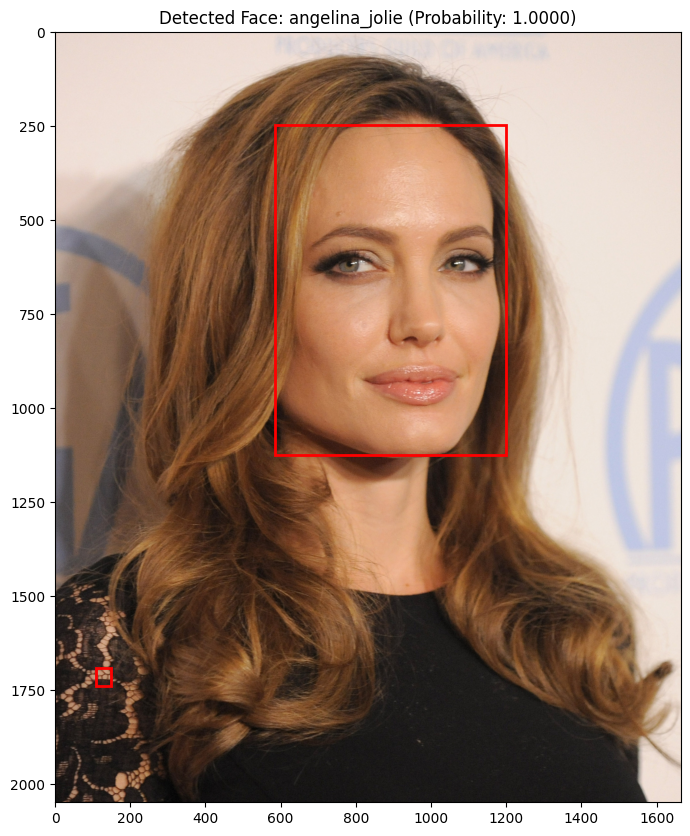

Face detected with probability: 0.99993408


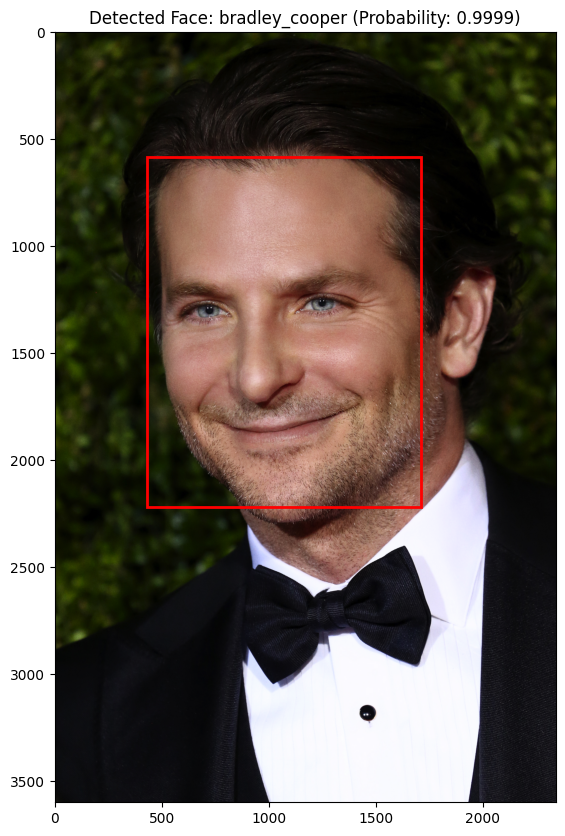

Face detected with probability: 0.99973291


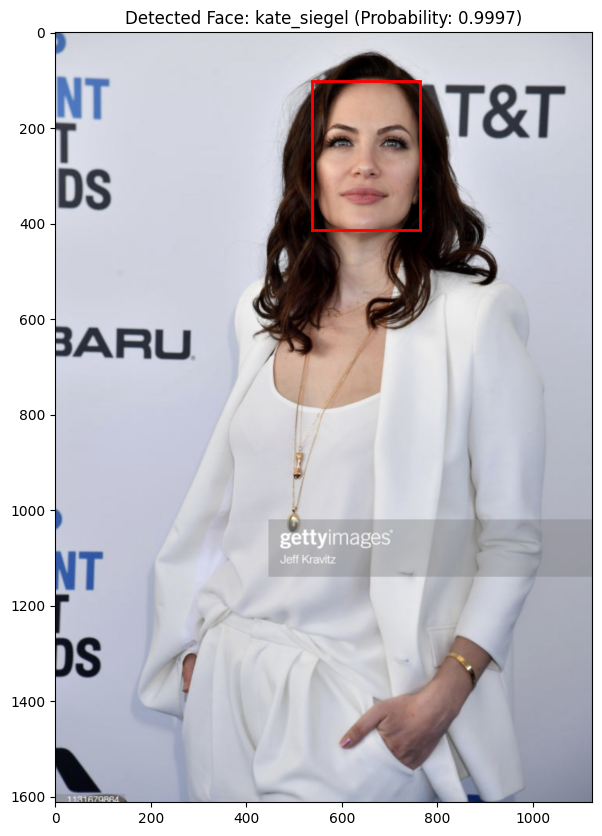

Face detected with probability: 0.99987614


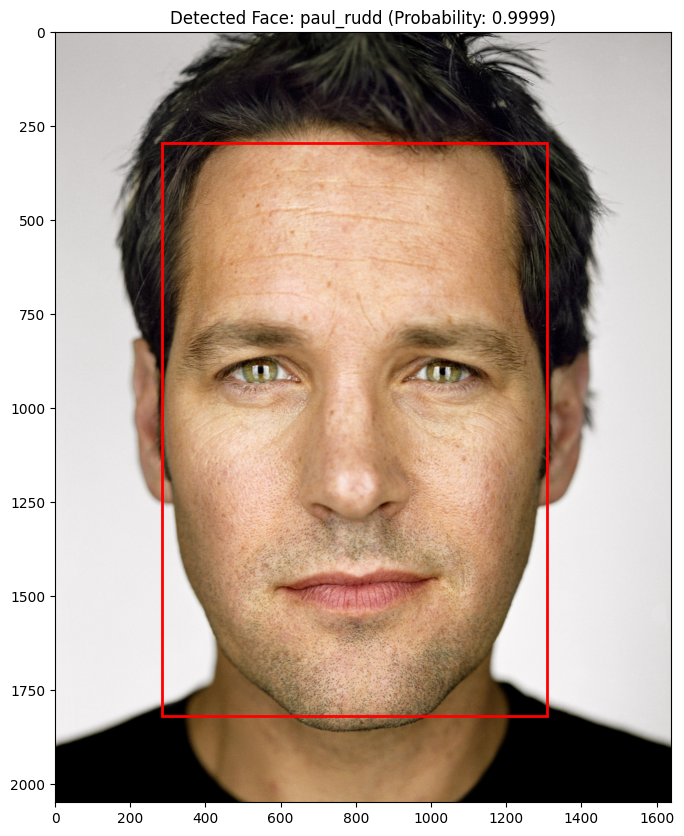

Face detected with probability: 0.99999237


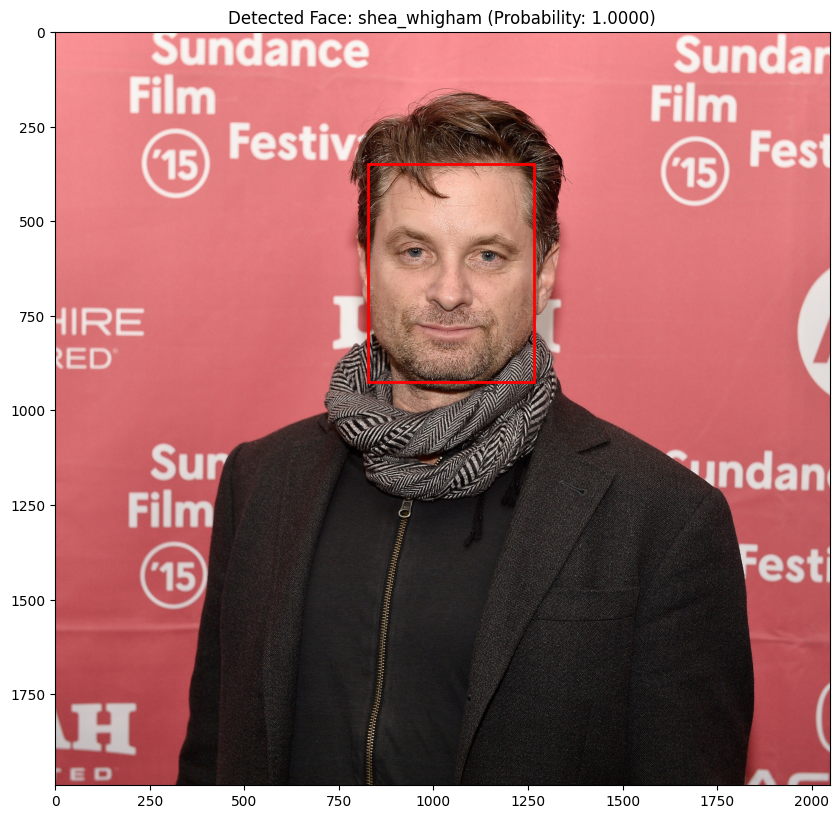

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image


to_pil = transforms.ToPILImage()

for x, y in loader:

    # face detection
    x_aligned, prob = mtcnn(x, return_prob=True)

    if x_aligned is not None:
        print(f'Face detected with probability: {prob:.8f}')

        original_img = x

        plt.figure(figsize=(10, 10))
        plt.imshow(original_img)

        boxes, _ = mtcnn.detect(x)

        if boxes is not None:
            for box in boxes:
                left, top, right, bottom = box
                plt.gca().add_patch(plt.Rectangle((left, top), right - left, bottom - top,
                                                  fill=False, color='red', linewidth=2))

        plt.title(f"Detected Face: {names[y]} (Probability: {prob:.4f})")
        plt.axis("on")
        plt.show()


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [ ]:
print(embeddings.shape)

torch.Size([5, 512])


#### Print distance matrix for classes

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.434377   
bradley_cooper        1.447480        0.000000     1.313749   1.011981   
kate_siegel           0.887728        1.313749     0.000000   1.388992   
paul_rudd             1.434377        1.011981     1.388992   0.000000   
shea_whigham          1.399073        1.038684     1.379655   1.104095   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379655  
paul_rudd           1.104095  
shea_whigham        0.000000  


### Detect face and extract feature

In [ ]:
from PIL import Image
def detect_face_and_extract_feature(image_path: str):

    img = Image.open(image_path)
    aligned_faces, probs = mtcnn(img, return_prob=True)

    if aligned_faces is None:
        print("No faces detected.")
        return [], []

    if not isinstance(aligned_faces, list):
        aligned_faces = [aligned_faces]

    print(f"Detected {len(aligned_faces)} face(s) with probabilities: {probs}")

    embeddings = []
    for face in aligned_faces:
        face_tensor = face.unsqueeze(0).to(device)
        embedding = resnet(face_tensor).detach()
        embeddings.append(embedding)

    return aligned_faces[0], embeddings[0]

### Create a Facial Database for face searching



*   Add faces to the facial database(offline)
*   Search Face from the facial database(online)



> We use Facebook Faiss Vector Database as our backend: https://github.com/facebookresearch/faiss





In [ ]:
import os
import faiss
import numpy as np
import random

class FaissWithMetadata:

    def __init__(self, index):
        self.index = index
        # self.metadata = {}

    def add(self, vectors, metadata):
        """
        Add vectors to the index and associate metadata.
        """
        # current_id = len(self.metadata)
        face_id = int(metadata['ID'][1:])
        print(f'face id: {face_id}')
        self.index.add_with_ids(vectors, np.array([face_id], dtype='int64'))

        # self.metadata[current_id + 1] = metadata


    def search(self, query, k):
        """
        Search for the nearest neighbors and return both the IDs and metadata.
        """
        distances, indices = self.index.search(query, k)
        # metadata = [self.metadata[idx] for idx in indices[0]]
        return distances, indices

In [ ]:
# record the indexing image with id
indexing_images = {}

def create_index_from_path(engine, path: str):

    if None == path or not os.path.exists(path):
        print(f'Path: {path} not found!')
        exit(0)

    selected_items = []
    for id in os.listdir(path):
        selected_item = random.choice(os.listdir(os.path.join(path, id)))
        selected_items.append(os.path.join(path, id, selected_item))

    for img_path in selected_items:
        if None == img_path or not os.path.exists(img_path):
            continue
        _, embed = detect_face_and_extract_feature(img_path)
        face_id = int(img_path.split('/')[-2][1:])
        indexing_images[face_id] = img_path
        print(f'Indexed Image: {img_path}')
        # print(f'embed: {embed.shape}')
        create_index_from_record(engine, embed.to('cpu').numpy(), {"ID": img_path.split('/')[-2]})

    print('Create Index successfully!')


def create_index_from_record(engine:FaissWithMetadata, embed, metadata):
    engine.add(embed, metadata)

# facial embed
dim_embed = 512
vector_db = faiss.IndexFlatL2(dim_embed)
index_with_ids = faiss.IndexIDMap(vector_db)
engine = FaissWithMetadata(index_with_ids)

# create faical dataset from the folder
create_index_from_path(engine, '/content/drive/MyDrive/CS566/dataset/val')


Detected 1 face(s) with probabilities: 0.9999985694885254
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n000736/0131_02.jpg
face id: 736
Detected 1 face(s) with probabilities: 0.9999123811721802
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n000706/0087_02.jpg
face id: 706
Detected 1 face(s) with probabilities: 0.999998927116394
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n000689/0096_01.jpg
face id: 689
Detected 1 face(s) with probabilities: 0.9995182752609253
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n000078/0217_02.jpg
face id: 78
Detected 1 face(s) with probabilities: 0.9943698048591614
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n001211/0307_02.jpg
face id: 1211
Detected 1 face(s) with probabilities: 0.9997789263725281
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n000998/0143_01.jpg
face id: 998
Detected 1 face(s) with probabilities: 0.9362499117851257
Indexed Image: /content/drive/MyDrive/CS566/dataset/val/n0003

### Efficient Face Searching

In [ ]:
import time

# testing dataset
val_path = '/content/drive/MyDrive/CS566/dataset/val'
val_id = random.choice(os.listdir(val_path))
test_img = os.path.join(val_path, val_id, random.choice(os.listdir(os.path.join(val_path ,val_id))))
print(f'Ground True: val_id={val_id}, image_Path={test_img}')

start_time = time.time()
query = detect_face_and_extract_feature(test_img)[1].to('cpu').numpy()
print(f'query: {query.shape}')
distances, result_face_ids = engine.search(query, 5)
elapsed_time = time.time() - start_time
print(f'cost: {elapsed_time:.6f}s')

for dist, face_id in zip(distances[0], result_face_ids):
    print(f"Distance: {dist:.4f}, Top-5 Results: {face_id}")

Ground True: val_id=n000912, image_Path=/content/drive/MyDrive/CS566/dataset/val/n000912/0770_01.jpg
Detected 1 face(s) with probabilities: 0.9999995231628418
query: (1, 512)
cost: 0.736453s
Distance: 0.8257, Top-5 Results: [ 912 1156 1296  452  785]


### Visualize the Face Matching Result

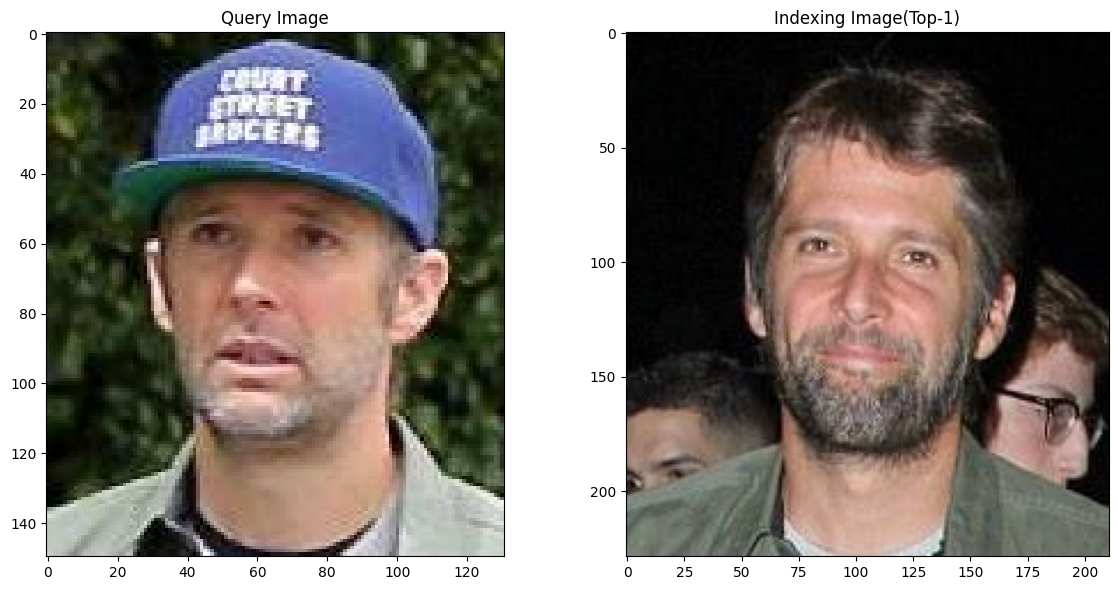

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(Image.open(test_img))
axes[0].set_title("Query Image")
axes[0].axis('on')

axes[1].imshow(Image.open(indexing_images[result_face_ids[0][0]]))
axes[1].set_title("Indexing Image(Top-1)")
axes[1].axis('on')


plt.tight_layout()
plt.show()